# Code for generating 1, bump activity; 2, place fields; 3, intrinsic speed in Figure 2

## Section 1: generate bump activity

In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from cann_fft import CANN1D
#set default ramndom seed for reproducibility
np.random.seed(123)
#set backend to cpu
bm.set_platform('cpu')

import warnings
warnings.filterwarnings("ignore")


/home/zilong/anaconda3/envs/anticipative_track/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Predict 15079 steps: : 100%|██████████| 15079/15079 [00:00<00:00, 73604.92it/s]


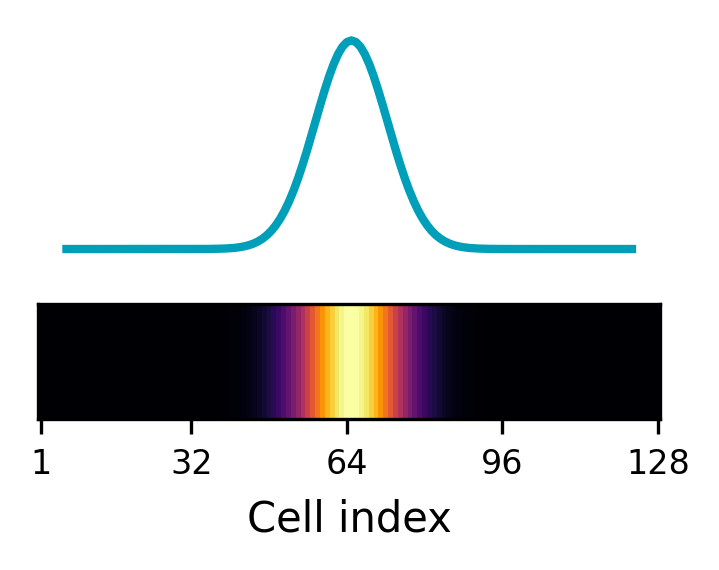

In [2]:

#create and run the network
cann = CANN1D(num=128, mbar=1)
v_ext = cann.a / cann.tau_v * 0.5
dur = 2 * bm.pi / v_ext
dt = bm.get_dt()
num = int(dur / dt)
time = np.linspace(0, dur, num)
final_pos = v_ext * dur
position = np.zeros(num)
position = position.reshape((-1, 1))
Iext = cann.get_stimulus_by_pos(position)

runner = bp.DSRunner(cann,
                     inputs=('input', Iext, 'iter'),
                     monitors=['u', 'v', 'r'])

runner.run(dur)
index = np.linspace(1, cann.num, cann.num)
# index = np.linspace(0, 300, 300)
fr = runner.mon.r
pos = position.squeeze()

#plot the figrue
# set some parameters
labelsize = 10
ticksize = 8
custom_color = '#009FB9'

#create twwo subplots with the first one is bigger than the second one
fig, axes = plt.subplots(nrows=2, figsize=(2.5,2), height_ratios=[2, 1], dpi=300)
#plot the line and set the line color to customized color
axes[0].plot(index, 1e3*fr[2000,:], linewidth=2, color=custom_color) 
#set axis off and box off in this subplot
axes[0].set_xticks([])
axes[0].set_yticks([])
for spine in axes[0].spines.values():
    spine.set_visible(False)
    
# plt.pcolormesh(index,position, fr[100:400,:])
im = axes[1].pcolormesh(index, time[2000:12000:50]-time[2000], 1e3*fr[2000:12000:50,:], cmap='inferno')
plt.xlabel('Cell index', fontsize=labelsize)

xticks = np.array([1,32,64,96,128])
axes[1].set_xticks(xticks)
axes[1].tick_params(axis='x', labelsize=ticksize)
axes[1].set_yticks([])
plt.tight_layout()

fig.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig2_networkbump.pdf', bbox_inches='tight')

## Section 2: generate place fields

Predict 15079 steps: : 100%|██████████| 15079/15079 [00:00<00:00, 78221.20it/s]


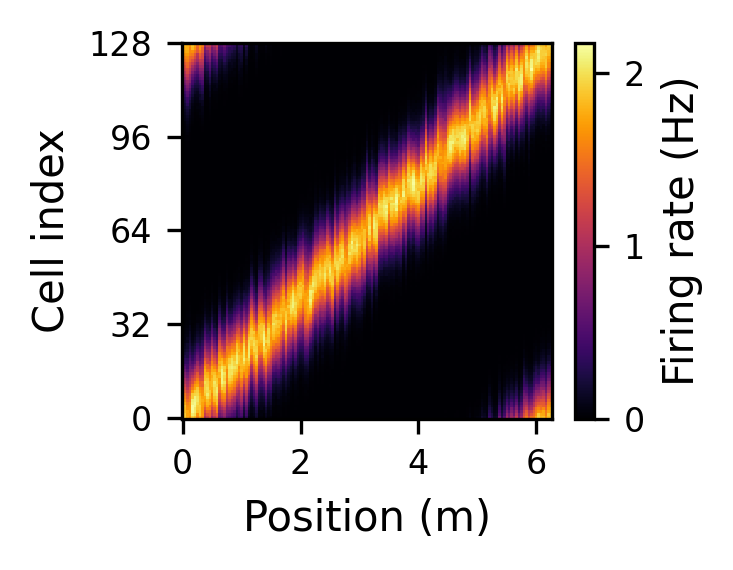

In [3]:
#create and run the network
cann = CANN1D(num=128, mbar=1)
v_ext = cann.a / cann.tau_v * 0.5
dur = 2 * bm.pi / v_ext
dt = bm.get_dt()
num = int(dur / dt)
time = np.linspace(0, dur, num)
final_pos = v_ext * dur
position = np.zeros(num)
position[0] = -np.pi
for i in range(num)[1:]:
    position[i] = position[i - 1] + v_ext * dt
    if position[i] > np.pi:
        position[i] -= 2 * np.pi

position = position.reshape((-1, 1))
noise = 0.01*np.random.randn(num,cann.num)
Iext = cann.get_stimulus_by_pos(position+0.5*np.random.randn(num,1)) + noise

runner = bp.DSRunner(cann,
                     inputs=('input', Iext, 'iter'),
                     monitors=['u', 'v', 'r'])

runner.run(dur)

fr = runner.mon.r.T
pos = position.squeeze()

# Plot the place field
# set some parameters
labelsize = 10
ticksize = 8
fig, ax = plt.subplots(figsize=(2.5, 2), dpi=300)

index = np.linspace(1, cann.num, cann.num)
#plt.pcolormesh(100*(pos[2000:12000:20]-pos[2000]), index[10:50]-index[10], 1e3*fr[10:50,2000:12000:20], cmap='inferno')
#do pcolormesh without slice
plt.pcolormesh(pos[::100]-pos[0], index-index[0], 1e3*fr[:,::100], cmap='inferno')

#add labels
plt.xlabel('Position (m)', fontsize=labelsize)
plt.ylabel('Cell index', fontsize=labelsize)

#set colorbar, add ticks 
clb = plt.colorbar(ticklocation='right', ticks=[0,1,2])
clb.set_label('Firing rate (Hz)', fontsize=labelsize)
#change the font size
clb.ax.tick_params(labelsize=ticksize)

yticks = [0,32,64,96,128]
ax.set_yticks(yticks)
#set x ticks
xticks = [0,2,4,6]
ax.set_xticks(xticks)

ax.tick_params(axis='x', labelsize=ticksize)
ax.tick_params(axis='y', labelsize=ticksize)
plt.tight_layout()

fig.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig2_placefield.pdf')

## Section 3: generate intrinsic speed varying with adaptation strength

0.0
0.038461538461538464
0.07692307692307693
0.11538461538461539
0.15384615384615385
0.19230769230769232
0.23076923076923078
0.2692307692307692
0.3076923076923077
0.34615384615384615
0.38461538461538464
0.4230769230769231
0.46153846153846156
0.5
0.5384615384615384
0.5769230769230769
0.6153846153846154
0.6538461538461539
0.6923076923076923
0.7307692307692307
0.7692307692307693
0.8076923076923077
0.8461538461538461
0.8846153846153846
0.9230769230769231
0.9615384615384616


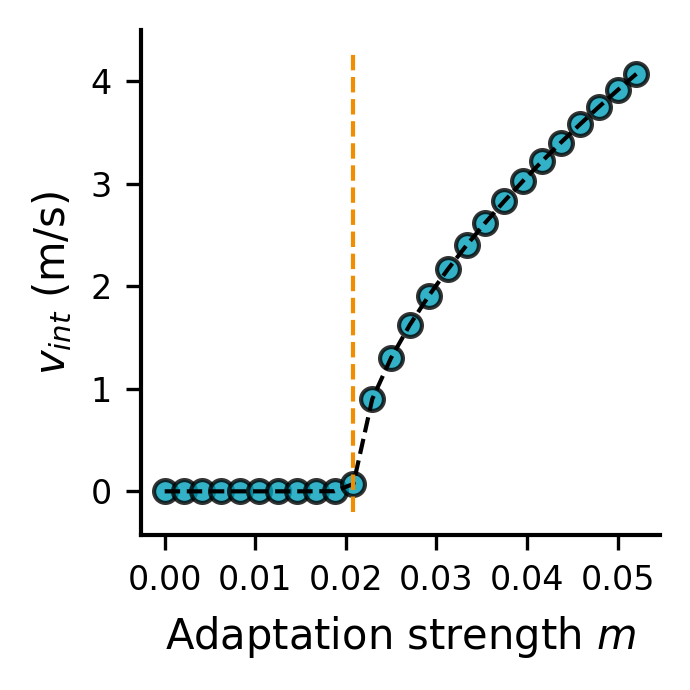

In [4]:
def intrinsic_speed(mbar=0, duration=5000):
    np.random.seed(0)
    cann = CANN1D(num=128, mbar=mbar, tau=3, tau_v=144)
    cann.reset_state()
    Iext, length = bp.inputs.section_input(
        values=[cann.get_stimulus_by_pos(0.), 0.],
        durations=[500., duration],
        return_length=True
    )
    noise = 0.02 * np.random.randn(len(Iext), cann.num)
    noise[5000:-1] = 0
    Iext = Iext + noise
    Iext = bm.as_numpy(Iext)
    runner = bp.DSRunner(cann,
                         inputs=('input', Iext, 'iter'),
                         monitors=['center'],
                         numpy_mon_after_run=False,
                         progress_bar=False)
    runner.run(length)
    center_trace = runner.mon.center[80000:-1]
    speed = bm.diff(center_trace, axis=0)
    mask = speed <= np.pi
    speed = speed[mask]
    v_int = bm.abs(np.mean(speed))*1e4
    # plt.plot(runner.mon.center)
    return v_int


num_p = 26
# monte_num = 20
Mbar = bm.linspace(0,2.5,num_p)
v_int = np.zeros(num_p,)
for i in range(num_p):
    v_int[i] = intrinsic_speed(mbar=Mbar[i], duration=15000)
    # print(v_int[i])
    print(i/num_p)
    
    
 #%%   
fig, ax = plt.subplots(figsize=(2.4, 2.4),dpi=300)
#set parameters for the figure
labelsize = 10
ticksize = 8
custom_color = '#009FB9'
# set the linewidth of each axis
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

#plot Mbar v.s. v_int with scatters and lines
plt.plot(Mbar*3/144, v_int, color='k', linewidth=1, linestyle='--')
#add scatter points
plt.scatter(Mbar*3/144, v_int, s=30, c='#009FB9', marker='o', alpha=0.8, edgecolors='k')    

plt.xlabel(r'Adaptation strength $m$', fontsize=labelsize)
plt.ylabel('$v_{int}$ (m/s)', fontsize=labelsize)

#set x and y ticks
xticks = [0,0.01,0.02,0.03,0.04,0.05]
yticks = [0.0,1.0,2.0,3.0,4.0]

ax.set_xticks(xticks)
ax.set_yticks(yticks)

#change y tick labels by timing 100
yticklabels = [str(int(i)) for i in yticks]
ax.set_yticklabels(yticklabels)

#add reference line of x=3/144
ymin, ymax = ax.get_ylim()
plt.plot([3/144,3/144],[ymin,ymax], color='#F18D00', linewidth=1, linestyle='--')

ax.tick_params(axis='x', labelsize=ticksize)
ax.tick_params(axis='y', labelsize=ticksize)

#set right and up axis  invisible
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
fig.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig2_intrinsicspeed.pdf')